In [3]:
import keras
import math
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from torch.utils.data import Dataset, DataLoader
import pickle
pd.set_option('display.max_rows', 500)
import os
import tensorflow as tf
import plotly.express as px
import torch
import torch.nn as nn
from math import sqrt
# import rmse from sklearn
from sklearn.metrics import mean_squared_error


# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)
tf.random.set_seed(0)
# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')

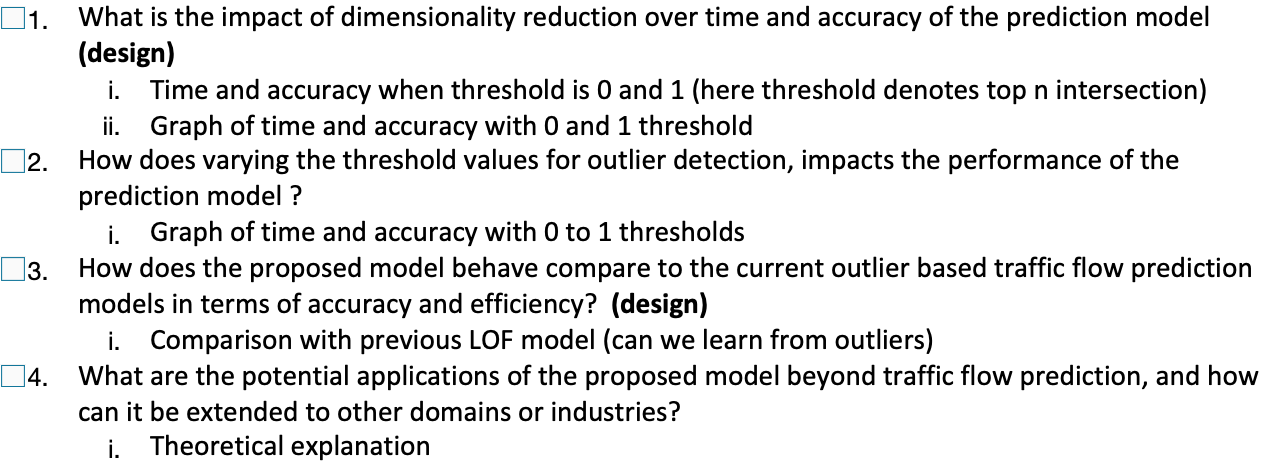

In [4]:
def mod_dict(results):
    new_dict = {}
    for key,val in results.items():
        new_key1 = key+'_'+'North'
        new_dict[new_key1] = val['North']
        new_key2 = key+'_'+'South'
        new_dict[new_key2] = val['South']
    return new_dict

In [5]:
def extract_results(results):
    thresholds = [0,0.05,0.1,0.25,0.5, 0.75, 1]
    result_dict = {}
    for val in thresholds:
        result_dict[val] = {}
        result_dict[val]['RMSE'] = []
        result_dict[val]['MAE'] = []
        result_dict[val]['train_time'] = []


    for intersection, value1 in results.items():
        for threshold, value2 in value1.items():
            result_dict[threshold]['RMSE'].append(value2['RMSE'])
            result_dict[threshold]['MAE'].append(value2['MAE'])
            result_dict[threshold]['train_time'].append(value2['train_time'])

    for intersection, value1 in results.items():
        for threshold, value2 in value1.items():
            result_dict[threshold]['RMSE'] = np.mean(result_dict[threshold]['RMSE'])
            result_dict[threshold]['MAE'] = np.mean(result_dict[threshold]['MAE'])
            result_dict[threshold]['train_time'] = np.mean(result_dict[threshold]['train_time'])

    return result_dict

#### ---------------------------- Hauge data processing ---------------------------- 

In [38]:
# results save path
outlier_model_name = 'DAE'
data_name = 'hauge'
base_result_path = f'../results/{data_name}/LSTM'
exp_name = f'univariate_{outlier_model_name}_outlier_weighted.pkl'
load_path = os.path.join(base_result_path, exp_name)

In [39]:
# load results
with open(load_path, 'rb') as f:
    results = pickle.load(f)

In [178]:
if data_name == 'hauge':
    results = mod_dict(results)

In [151]:
result_dict = extract_results(results)

In [152]:
# make dataframe
df = pd.DataFrame(result_dict).T
df['threshold'] = df.index
df['threshold'] = df['threshold'].astype(str)
df.reset_index(drop=True, inplace=True)
df

,RMSE,MAE,train_time,threshold
0,14.233574,9.974824,713.070726,0.0
1,14.196027,9.955481,707.724939,0.05
2,14.063914,9.852005,708.429502,0.1
3,13.834366,9.650149,713.855183,0.25
4,14.042241,9.903082,719.537796,0.5
5,13.560710,9.468268,719.682254,0.75
6,13.723998,9.856865,720.057995,1.0


In [153]:
fig = px.bar(df, x='threshold', y=['RMSE','MAE'], text_auto=True,barmode='group', title='RMSE vs Threshold')
# fig = px.line(df, x='threshold', y='RMSE', title='RMSE vs Threshold')
fig.show()

In [154]:
# fig = px.line(df, x='threshold', y='train_time', title='RMSE vs Threshold')
fig = px.bar(df, x='threshold', y='train_time', text_auto=True, title='RMSE vs Threshold')
fig.show()

In [155]:
# normalize dataframe 
df_min_max_scaled = df.copy()
# apply normalization techniques
for column in df_min_max_scaled.columns[:-1]:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min()) 
df_min_max_scaled

,RMSE,MAE,train_time,threshold
0,1.000000,1.000000,0.433452,0.0
1,0.944198,0.961814,0.000000,0.05
2,0.747853,0.757541,0.057128,0.1
3,0.406703,0.359054,0.497058,0.25
4,0.715644,0.858373,0.957821,0.5
5,0.000000,0.000000,0.969534,0.75
6,0.242676,0.767135,1.000000,1.0


In [156]:
fig = px.line(df_min_max_scaled, x='threshold', y=['train_time', 'RMSE'],title='RMSE vs Threshold')
fig.show()

#### ---------------------------- METR data processing ---------------------------- 

In [157]:
# results save path
outlier_model_name = 'DAE'
data_name = 'METR-LA'
base_result_path = f'../results/{data_name}/LSTM'
exp_name = f'univariate_{outlier_model_name}_outlier_weighted.pkl'
load_path = os.path.join(base_result_path, exp_name)

In [158]:
# load results
with open(load_path, 'rb') as f:
    results = pickle.load(f)

In [159]:
if data_name == 'hauge':
    results = mod_dict(results)

In [160]:
result_dict = extract_results(results)

In [161]:
# make dataframe
df = pd.DataFrame(result_dict).T
df['threshold'] = df.index
df['threshold'] = df['threshold'].astype(str)
df.reset_index(drop=True, inplace=True)
df

,RMSE,MAE,train_time,threshold
0,6.299700,3.145351,178.684204,0.0
1,5.962101,2.817317,208.048563,0.05
2,6.000140,2.905632,224.465627,0.1
3,6.010038,2.980931,287.318265,0.25
4,8.480971,3.806029,389.816246,0.5
5,8.855737,4.356826,608.582885,0.75
6,8.128413,4.326492,804.052115,1.0


In [162]:
fig = px.bar(df, x='threshold', y=['RMSE','MAE'], text_auto=True,barmode='group', title='RMSE vs Threshold')
# fig = px.line(df, x='threshold', y='RMSE', title='RMSE vs Threshold')
fig.show()

In [163]:
# fig = px.line(df, x='threshold', y='train_time', title='RMSE vs Threshold')
fig = px.bar(df, x='threshold', y='train_time', text_auto=True, title='RMSE vs Threshold')
fig.show()

In [164]:
# normalize dataframe 
df_min_max_scaled = df.copy()
# apply normalization techniques
for column in df_min_max_scaled.columns[:-1]:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min()) 
df_min_max_scaled

,RMSE,MAE,train_time,threshold
0,0.116669,0.213077,0.000000,0.0
1,0.000000,0.000000,0.046955,0.05
2,0.013146,0.057366,0.073207,0.1
3,0.016566,0.106277,0.173712,0.25
4,0.870486,0.642225,0.337613,0.5
5,1.000000,1.000000,0.687433,0.75
6,0.748647,0.980296,1.000000,1.0


In [165]:
fig = px.line(df_min_max_scaled, x='threshold', y=['train_time', 'RMSE'],title='RMSE vs Threshold')
fig.show()

#### ---------------------------- The comparision between outlier models ---------------------------- 

In [7]:
def get_results(base_result_path, exp_name):
    load_path = os.path.join(base_result_path, exp_name)
    with open(load_path, 'rb') as f:
        results = pickle.load(f)

    if data_name == 'hauge':
        results = mod_dict(results)

    result_dict = extract_results(results)
    
    # make dataframe
    df = pd.DataFrame(result_dict).T
    df['threshold'] = df.index
    df['threshold'] = df['threshold'].astype(str)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [15]:
# results save path
outlier_model_name = 'LOF'
data_name = 'hauge'
base_result_path = f'../results/{data_name}/LSTM'
exp_name = f'univariate_{outlier_model_name}_outlier_weighted.pkl'
df_lof = get_results(base_result_path, exp_name)
df_lof = df_lof.iloc[:5]

In [16]:
# results save path
outlier_model_name = 'DAE'
data_name = 'hauge'
base_result_path = f'../results/{data_name}/LSTM'
exp_name = f'univariate_{outlier_model_name}_outlier_weighted.pkl'
df_DAE = get_results(base_result_path, exp_name)

In [17]:
# results save path
outlier_model_name = 'AE'
data_name = 'hauge'
base_result_path = f'../results/{data_name}/LSTM'
exp_name = f'univariate_{outlier_model_name}_outlier_weighted.pkl'
df_AE = get_results(base_result_path, exp_name)

In [32]:
min_score = {'LOF':[df_lof['RMSE'].min()],'DAE':[df_DAE['RMSE'].min()],'AE':[df_AE['RMSE'].min()]}
min_score = pd.DataFrame(min_score).T
min_score.columns = ['RMSE']
min_score

,RMSE
LOF,13.717433
DAE,13.560710
AE,13.585192


In [34]:
# fig = px.line(df, x='threshold', y='train_time', title='RMSE vs Threshold')
fig = px.bar(min_score,title='outlier models',text_auto=True)
fig.show()

# REAL TIME RESULT ANALYSIS

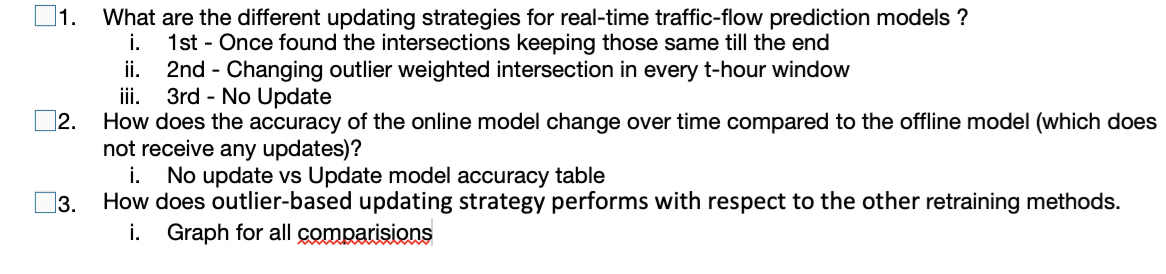

#### ---------------------------- Hauge data processing ---------------------------- 

In [182]:
# results save path
outlier_model_name = 'DAE'
data_name = 'hauge'
time_window = 3
threshold = 0.75
base_result_path = f'../results/{data_name}/real_time_modeling'
exp_name = f'univariate_real_time_{outlier_model_name}_threshold_{threshold}_{time_window}H.pkl'
load_path = os.path.join(base_result_path, exp_name)

In [183]:
# laod results
with open(load_path, 'rb') as f:
    results = pickle.load(f)

In [185]:
if data_name == 'hauge':
    results = mod_dict(results)

In [186]:
model_types = ['incremental_weighted_update','incremental_static_update','No_update']
result_dict = {}
result_dict['incremental_weighted_update'] = {}
result_dict['incremental_static_update'] = {}
result_dict['No_update'] = {}
result_dict['incremental_weighted_update']['Timestamp'] = []
result_dict['incremental_static_update']['Timestamp'] = []
result_dict['No_update']['Timestamp'] = []


for intersection, value1 in results.items():
    data = value1[0.75]
    incremental_weighted_update_data = data['incremental_weighted_update']
    incremental_static_update_data = data['incremental_static_update']
    no_update_data = data['No_update']

    result_dict['incremental_weighted_update'][intersection] = []
    result_dict['incremental_static_update'][intersection] = []
    result_dict['No_update'][intersection] = []
    result_dict['incremental_weighted_update']['Timestamp'] = []
    result_dict['incremental_static_update']['Timestamp'] = []
    result_dict['No_update']['Timestamp'] = []

    for key, value in incremental_weighted_update_data.items():
        result_dict['incremental_weighted_update'][intersection].append(value['RMSE'])
        result_dict['incremental_weighted_update']['Timestamp'].append(key)
    for key, value in incremental_static_update_data.items():
        result_dict['incremental_static_update'][intersection].append(value['RMSE'])
        result_dict['incremental_static_update']['Timestamp'].append(key)
    for key, value in no_update_data.items():
        result_dict['No_update'][intersection].append(value['RMSE'])
        result_dict['No_update']['Timestamp'].append(key)


In [187]:
df1 = pd.DataFrame(result_dict['incremental_weighted_update']) # take mean of all columns except timestamp
df1['mean'] = df1.mean(axis=1)
df1.rename(columns={'mean':'incremental_weighted_update'}, inplace=True) # rename mean column to incremental_weighted_update
df1 = df1[['Timestamp','incremental_weighted_update']] # select only timestamp and incremental_weighted_update columns
df1.head()

,Timestamp,incremental_weighted_update
0,2019-02-16 03:00:00,65.759712
1,2019-02-16 06:00:00,38.508810
2,2019-02-16 09:00:00,22.557152
3,2019-02-16 12:00:00,78.023195
4,2019-02-16 15:00:00,92.993168


In [188]:
df2 = pd.DataFrame(result_dict['incremental_static_update']) # take mean of all columns except timestamp
df2['mean'] = df2.mean(axis=1)
df2.rename(columns={'mean':'incremental_static_update'}, inplace=True) # rename mean column to incremental_weighted_update
df2 = df2[['Timestamp','incremental_static_update']]
df2.head()

,Timestamp,incremental_static_update
0,2019-02-16 03:00:00,65.232043
1,2019-02-16 06:00:00,37.630549
2,2019-02-16 09:00:00,22.580669
3,2019-02-16 12:00:00,78.710645
4,2019-02-16 15:00:00,92.033099


In [189]:
df3 = pd.DataFrame(result_dict['No_update']) # take mean of all columns except timestamp
df3['mean'] = df3.mean(axis=1)
df3.rename(columns={'mean':'No_update'}, inplace=True) # rename mean column to incremental_weighted_update
df3 = df3[['Timestamp','No_update']]
df3.head()

,Timestamp,No_update
0,2019-02-16 03:00:00,65.232043
1,2019-02-16 06:00:00,65.964367
2,2019-02-16 09:00:00,34.412290
3,2019-02-16 12:00:00,42.026543
4,2019-02-16 15:00:00,67.290734


In [190]:
# merge dataframes on timestamp
df = pd.merge(df1, df2, on='Timestamp')
df = pd.merge(df, df3, on='Timestamp')
df.head()

,Timestamp,incremental_weighted_update,incremental_static_update,No_update
0,2019-02-16 03:00:00,65.759712,65.232043,65.232043
1,2019-02-16 06:00:00,38.508810,37.630549,65.964367
2,2019-02-16 09:00:00,22.557152,22.580669,34.412290
3,2019-02-16 12:00:00,78.023195,78.710645,42.026543
4,2019-02-16 15:00:00,92.993168,92.033099,67.290734


In [191]:
fig = px.line(df, x='Timestamp', y=['incremental_weighted_update', 'incremental_static_update','No_update'],title='RMSE vs time')
fig.show()

In [192]:
# calculate mean of all columns 
temp = pd.DataFrame(df.mean(axis = 0), columns=['RMSE'])
temp['model'] = temp.index
temp.reset_index(drop=True, inplace=True)
temp

,RMSE,model
0,41.270614,incremental_weighted_update
1,40.442322,incremental_static_update
2,46.087276,No_update


In [193]:
fig = px.bar(temp, x='model', y='RMSE', text_auto=True, title='RMSE vs model')
fig.show()

#### ---------------------------- METR-LA data processing ---------------------------- 

In [166]:
# results save path
outlier_model_name = 'DAE'
data_name = 'METR-LA'
time_window = 3
threshold = 0.05
base_result_path = f'../results/{data_name}/real_time_modeling'
exp_name = f'univariate_real_time_{outlier_model_name}_threshold_{threshold}_{time_window}H.pkl'
load_path = os.path.join(base_result_path, exp_name)

In [167]:
# laod results
with open(load_path, 'rb') as f:
    results = pickle.load(f)

In [168]:
model_types = ['incremental_weighted_update','incremental_static_update','No_update']
result_dict = {}
result_dict['incremental_weighted_update'] = {}
result_dict['incremental_static_update'] = {}
result_dict['No_update'] = {}
result_dict['incremental_weighted_update']['Timestamp'] = []
result_dict['incremental_static_update']['Timestamp'] = []
result_dict['No_update']['Timestamp'] = []


for intersection, value1 in results.items():
    data = value1[0.05]
    incremental_weighted_update_data = data['incremental_weighted_update']
    incremental_static_update_data = data['incremental_static_update']
    no_update_data = data['No_update']

    result_dict['incremental_weighted_update'][intersection] = []
    result_dict['incremental_static_update'][intersection] = []
    result_dict['No_update'][intersection] = []
    result_dict['incremental_weighted_update']['Timestamp'] = []
    result_dict['incremental_static_update']['Timestamp'] = []
    result_dict['No_update']['Timestamp'] = []

    for key, value in incremental_weighted_update_data.items():
        result_dict['incremental_weighted_update'][intersection].append(value['RMSE'])
        result_dict['incremental_weighted_update']['Timestamp'].append(key)
    for key, value in incremental_static_update_data.items():
        result_dict['incremental_static_update'][intersection].append(value['RMSE'])
        result_dict['incremental_static_update']['Timestamp'].append(key)
    for key, value in no_update_data.items():
        result_dict['No_update'][intersection].append(value['RMSE'])
        result_dict['No_update']['Timestamp'].append(key)


In [169]:
df1 = pd.DataFrame(result_dict['incremental_weighted_update']) # take mean of all columns except timestamp
df1['mean'] = df1.mean(axis=1)
df1.rename(columns={'mean':'incremental_weighted_update'}, inplace=True) # rename mean column to incremental_weighted_update
df1 = df1[['Timestamp','incremental_weighted_update']] # select only timestamp and incremental_weighted_update columns
df1.head()

,Timestamp,incremental_weighted_update
0,2012-04-29 15:00:00,15.794091
1,2012-04-29 18:00:00,44.533632
2,2012-04-29 21:00:00,32.097457
3,2012-04-30 00:00:00,29.358020
4,2012-04-30 03:00:00,9.959567


In [170]:
df2 = pd.DataFrame(result_dict['incremental_static_update']) # take mean of all columns except timestamp
df2['mean'] = df2.mean(axis=1)
df2.rename(columns={'mean':'incremental_static_update'}, inplace=True) # rename mean column to incremental_weighted_update
df2 = df2[['Timestamp','incremental_static_update']]
df2.head()

,Timestamp,incremental_static_update
0,2012-04-29 15:00:00,15.963201
1,2012-04-29 18:00:00,43.990069
2,2012-04-29 21:00:00,33.783782
3,2012-04-30 00:00:00,28.429096
4,2012-04-30 03:00:00,12.301638


In [171]:
df3 = pd.DataFrame(result_dict['No_update']) # take mean of all columns except timestamp
df3['mean'] = df3.mean(axis=1)
df3.rename(columns={'mean':'No_update'}, inplace=True) # rename mean column to incremental_weighted_update
df3 = df3[['Timestamp','No_update']]
df3.head()

,Timestamp,No_update
0,2012-04-29 15:00:00,15.963201
1,2012-04-29 18:00:00,39.637098
2,2012-04-29 21:00:00,12.889817
3,2012-04-30 00:00:00,19.167736
4,2012-04-30 03:00:00,18.787956


In [172]:
# merge dataframes on timestamp
df = pd.merge(df1, df2, on='Timestamp')
df = pd.merge(df, df3, on='Timestamp')
df.head()

,Timestamp,incremental_weighted_update,incremental_static_update,No_update
0,2012-04-29 15:00:00,15.794091,15.963201,15.963201
1,2012-04-29 18:00:00,44.533632,43.990069,39.637098
2,2012-04-29 21:00:00,32.097457,33.783782,12.889817
3,2012-04-30 00:00:00,29.358020,28.429096,19.167736
4,2012-04-30 03:00:00,9.959567,12.301638,18.787956


In [173]:
fig = px.line(df, x='Timestamp', y=['incremental_weighted_update', 'incremental_static_update','No_update'],title='RMSE vs time')
fig.show()

In [174]:
# calculate mean of all columns 
temp = pd.DataFrame(df.mean(axis = 0), columns=['RMSE'])
temp['model'] = temp.index
temp.reset_index(drop=True, inplace=True)
temp

,RMSE,model
0,13.516418,incremental_weighted_update
1,13.029078,incremental_static_update
2,18.527539,No_update


In [175]:
fig = px.bar(temp, x='model', y='RMSE', text_auto=True, title='RMSE vs model')
fig.show()

# ----------------------- END ----------------------------

In [ ]:
# results save path
base_result_path = '../results/METR-LA/LSTM'
exp_name = 'multivariate_AE_weighted_vector_real_time_results.pkl'
results_save_path = os.path.join(base_result_path, exp_name)

In [ ]:
columns_names = ['717508','772151','767366','769405','769388','716951','717497','717483','717468','772596','772597','717469','764120','772178','769941','760024','771673','771667','765604','765176','773927','717480','717456','717495','716953','717481','767572','718371','769403','769359','716943','717491','767610','717446','717452','717453','717447','716956','717490','716942','773880','718204','769358','769402','767573','769953','773062','765164','772140','772168','769372','716571','716968','717492','717486','769819','717445','773869','769831','717450','716941','716955','717493','764858','769373','765171','768469','773012','717580','773953','763995','718499','716339','718089','718076','717608','769467','772669','717595','773013','717583','759772','764424','717804','764949','717582','773996','717592','759602','764781','767471','718064','767470','765273','764794','773954','717578','717587','773995','717585','769926','716328','765265','761003','718072','769847','718066','761599','765099','760650','717816','761604','717590','774012','717576','774204','767495','767494','759591','716331','762329','767523','767053','773024','774011','764766','767509','717818','767455','769444','716939','717825','767454','717819','773974','717570','718496','717821','737529','718045','716337','717571','773975','717573','764760','769867','718090','772513','717610','717823','769443','717572','773023','773939','767541','769418','769430','716958','717461','717460','716554','769431','764101','767554','773904','765182','718141','760987','717502','773906','767542','772167','717099','767350','767620','717489','717462','717463','767609','717488','767621','767351','774067','767751','717513','764106','768066','764853','717498','717473','717472','769806','717466','717499','769345','767585','718379','773916','767750','717504','717510','716949','717458','717465','717459','716960','769346']

In [ ]:
with open(results_save_path, 'rb') as f:
    results1 = pickle.load(f)

In [ ]:
org_df = pd.DataFrame(results1[0]['df']['Real'],columns=columns_names)
pred_df = pd.DataFrame(results1[0]['df']['Predicted'],columns=columns_names)

In [ ]:
sqrt(mean_squared_error(org_df['773062'].values,pred_df['773062'].values))

In [ ]:
org_df['717445']

# Real-Time result Analysis

In [75]:
target = '737529'
threshold = 0.05
time_window = 24

In [76]:
base_result_path = '../results/METR-LA/real_time_modeling/'
exp_name = f'univariate_AE_real_time_processing_threshold_{threshold}_{time_window}H_results_{target}.pkl'
results_load_path = os.path.join(base_result_path, exp_name)

In [77]:
# load results
with open(results_load_path, 'rb') as f:
    results_real_time = pickle.load(f)

In [78]:
results_real_time[target][threshold].keys()

dict_keys(['incremental_weighted_update', 'incremental_update', 'No_update', 'base_model'])

In [79]:
# get the average rmse and mae from all the experiments
def get_results(results_real_time, target, threshold, exp = 'No_update'):
    rmse = []
    mae = []
    train_time = []
    for key,val in results_real_time[target][threshold][exp].items():
        rmse.append(val['RMSE'])
        mae.append(val['MAE'])
        if exp != 'No_update':
            train_time.append(val['train_time'])
        else:
            train_time.append(0)
    print(f'RMSE: {np.mean(rmse)}')
    print(f'MAE: {np.mean(mae)}')
    print(f'Train time: {np.mean(train_time)}')
    # return rmse, mae, train_time

In [80]:
get_results(results_real_time, target, threshold, exp = 'incremental_weighted_update')

RMSE: 12.044180856281702
MAE: 7.845166206359863
Train time: 0.021019895197981496


In [81]:
get_results(results_real_time, target, threshold, exp = 'incremental_update')

RMSE: 12.00008107819342
MAE: 7.815212726593018
Train time: 0.01784764710119215


In [82]:
get_results(results_real_time, target, threshold, exp = 'No_update')

RMSE: 11.296915006448161
MAE: 7.359277725219727
Train time: 0.0


In [72]:
get_results(results_real_time, target, threshold, exp = 'incremental_weighted_update')

RMSE: 12.335480324885852
MAE: 10.86701488494873
Train time: 0.005507672962389494


In [73]:
get_results(results_real_time, target, threshold, exp = 'incremental_update')

RMSE: 12.402022270190002
MAE: 10.887054443359375
Train time: 0.005451359497873407


In [74]:
get_results(results_real_time, target, threshold, exp = 'No_update')

RMSE: 16.142935782701766
MAE: 12.458470344543457
Train time: 0.0


In [56]:
get_results(results_real_time, target, threshold, exp = 'incremental_weighted_update')

RMSE: 11.751373090139266
MAE: 10.418865203857422
Train time: 0.005428610851890162


In [57]:
get_results(results_real_time, target, threshold, exp = 'incremental_update')

RMSE: 11.72788030884934
MAE: 10.371858596801758
Train time: 0.00535873764439633


In [58]:
get_results(results_real_time, target, threshold, exp = 'No_update')

RMSE: 15.328964989254983
MAE: 12.401187896728516
Train time: 0.0
